In [1]:
from datasets import load_dataset
ds = load_dataset("tianharjuno/twitter-parse", cache_dir="cache/")
ds = ds["train"]

/Users/christianharjuno/anaconda3/envs/sentiment/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds_text_only = ds["content"]

In [4]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.corpus import stopwords
import requests

# Sastrawi
factory = StopWordRemoverFactory()
stopwords_id = set(factory.get_stop_words())

# English
stopwords_en = set(stopwords.words('english'))

# IndoNLU
indonlu_url = "https://raw.githubusercontent.com/indobenchmark/indonlu/master/utils/stopwordbahasa.txt"
stopwords_indonlu = set(requests.get(indonlu_url).text.split())

# IDN stopwords
idn_url = "https://raw.githubusercontent.com/aliakbar09/IDN-stopwords/master/idn_stopwords.txt"
stopwords_idn = set(requests.get(idn_url).text.split())

# Colloquial extensions (dialect + slang)
extra_slang = {
    "ga","gak","nggak","ngga","aja","nih","dong","deh","lah","loh","kok",
    "kan","nya","ya","emang","tau","yg","pd","trs","pls","plis","thx","makasih",
    "makasi","terimakasih","bgt","bngt","bener","btw","rt","dm","gw","gue","lu",
    "loe","lo","gua","ny","nya","jd","jadi","trs","sih","kayak","kek","oke",
    "ok","bro","sis","min","kalo","kalau","dgn","dengan","bikin","nih","dong"
}

# Combine and lowercase normalize
combined_stopwords = set(
    word.lower() for word in (
        stopwords_id |
        stopwords_en |
        stopwords_indonlu |
        stopwords_idn |
        extra_slang
    )
)

print(len(combined_stopwords), "total stopwords")

372 total stopwords


In [5]:
import re
def remove_stopwords(row):
    text = str(row["content"])
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in combined_stopwords]
    text = " ".join(filtered_words)
    row["content"] = text
    return row
HASHTAG_RE = re.compile(r'(?<!\w)#[\w_]+', flags=re.UNICODE)

def remove_hashtags(row):
    """
    Remove hashtags from the 'content' field of a dataframe row.
    """
    text = str(row["content"])
    text = HASHTAG_RE.sub('', text)
    text = re.sub(r'\s+', ' ', text).strip()
    row["content"] = text
    return row


Map: 100%|██████████| 201583/201583 [00:05<00:00, 36621.42 examples/s]


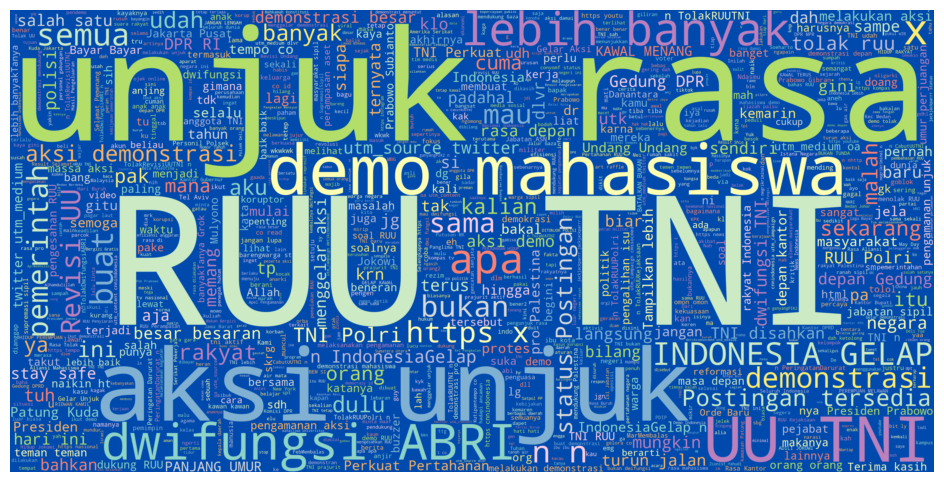

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text into one string

ds = ds.map(remove_hashtags)
ds = ds.map(remove_stopwords)
text = " ".join(ds["content"])

# # Generate the word cloud
wordcloud = WordCloud(
    width=3200,
    height=1600,
    background_color="#004aad",
    max_words=1000,
    colormap="Set3"  # or 'plasma', 'inferno', 'Set2', etc.
).generate(text)

# Display it
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


Generating plot with sentiment and data volume...
Plot saved as weekly_sentiment_and_volume_plot.png


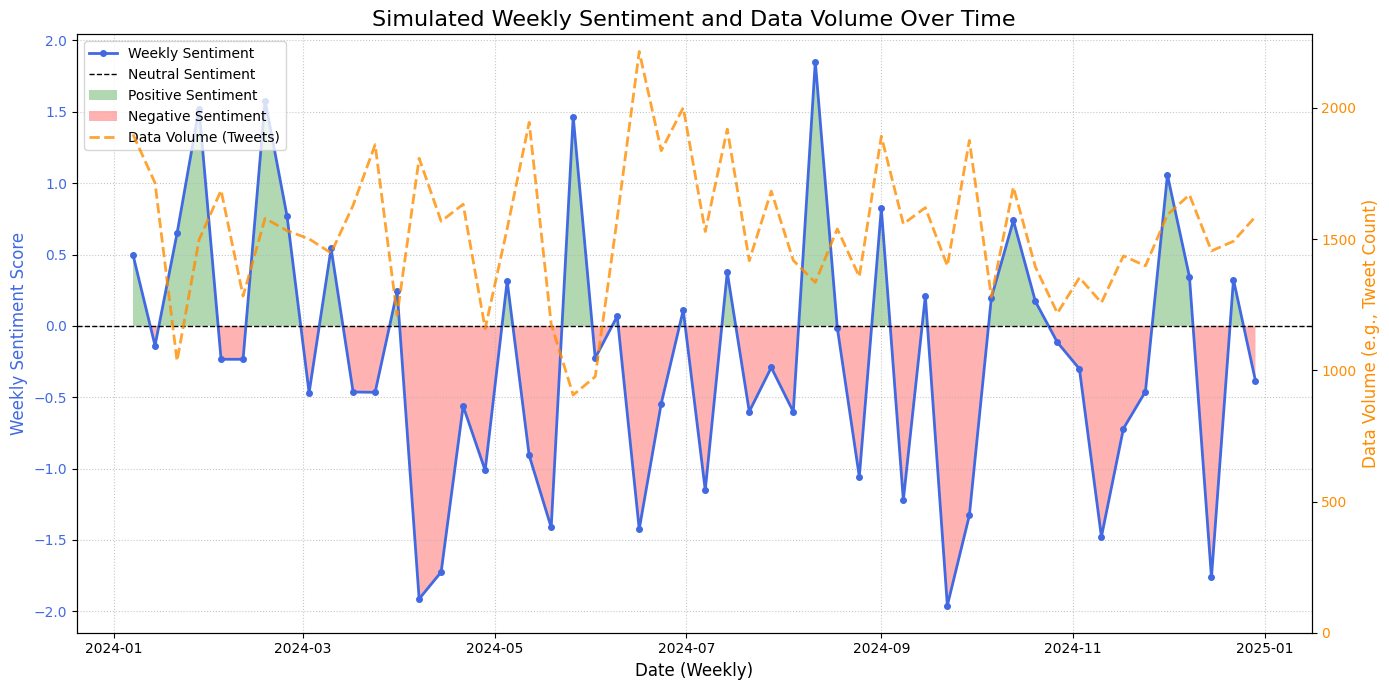

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Generate Sample Data ---

# Create a weekly date range for 52 weeks (one year)
dates = pd.date_range(start='2024-01-01', periods=52, freq='W')

# Simulate sentiment fluctuations *per week* (non-cumulative)
np.random.seed(42)  # Use a seed for reproducible results
sentiment_scores = np.random.randn(52)
sentiment_series = pd.Series(sentiment_scores, index=dates)

# --- NEW: Generate sample data for *counts* ---
# Simulate a fluctuating number of tweets, e.g., mean=1500, std_dev=300
np.random.seed(10) # Use a different seed
data_counts = np.abs(np.random.normal(loc=1500, scale=300, size=52)).astype(int)
count_series = pd.Series(data_counts, index=dates)

print("Generating plot with sentiment and data volume...")

# --- 2. Plot the Results (with Dual Axis) ---

# Set up the figure and the first axis (ax1)
fig, ax1 = plt.subplots(figsize=(14, 7))

# --- Plot 1: Sentiment Score (on ax1) ---

# Plot the main sentiment line
ax1.plot(sentiment_series, 
         label='Weekly Sentiment', 
         color='royalblue', 
         linewidth=2, 
         marker='o', 
         markersize=4,
         linestyle='-')

# Add the horizontal line in the middle (at y=0)
ax1.axhline(0, 
            color='black', 
            linestyle='--', 
            linewidth=1, 
            label='Neutral Sentiment')

# Fill the area above and below the zero line
ax1.fill_between(sentiment_series.index, 
                 sentiment_series, 
                 0, 
                 where=(sentiment_series > 0), 
                 facecolor='green', 
                 alpha=0.3, 
                 interpolate=True,
                 label='Positive Sentiment')
                 
ax1.fill_between(sentiment_series.index, 
                 sentiment_series, 
                 0, 
                 where=(sentiment_series <= 0), 
                 facecolor='red', 
                 alpha=0.3, 
                 interpolate=True,
                 label='Negative Sentiment')

# Customize ax1 (the left y-axis)
ax1.set_title('Simulated Weekly Sentiment and Data Volume Over Time', fontsize=16)
ax1.set_xlabel('Date (Weekly)', fontsize=12)
ax1.set_ylabel('Weekly Sentiment Score', fontsize=12, color='royalblue')
ax1.tick_params(axis='y', labelcolor='royalblue')
ax1.grid(True, linestyle=':', alpha=0.7)

# --- Plot 2: Data Count (on ax2) ---

# Create a second y-axis (ax2) that shares the same x-axis
ax2 = ax1.twinx() 

# Plot the data count line
ax2.plot(count_series, 
         label='Data Volume (Tweets)', 
         color='darkorange', 
         linewidth=2, 
         linestyle='--',  # Use a different style
         alpha=0.8)

# Customize ax2 (the right y-axis)
ax2.set_ylabel('Data Volume (e.g., Tweet Count)', fontsize=12, color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')
ax2.set_ylim(bottom=0) # Count can't be negative, so start axis at 0

# --- 3. Combine Legends for Both Axes ---
# This is a common trick for dual-axis plots
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

# Ensure the layout fits well
fig.tight_layout()

# Save the plot to a file
plt.savefig("weekly_sentiment_and_volume_plot.png")

print("Plot saved as weekly_sentiment_and_volume_plot.png")